In [1]:
import pandas as pd, numpy as np
import pymysql, re, collections
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'

from pathlib import Path
from tqdm import tqdm
from datetime import datetime
from collections import Counter
from wordcloud import WordCloud
from konlpy.tag import Okt
from PIL import Image

from tensorflow.keras.models import load_model
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer

pd.set_option('display.max_columns', None)

def live_db_conn():
    conn = pymysql.connect(host='host', user='user', password='password',autocommit=True,cursorclass=pymysql.cursors.DictCursor, db = "database")
    return conn

def dev_01_db_conn() :
    conn = pymysql.connect(host='host', user='user', password='password',autocommit=True,cursorclass=pymysql.cursors.DictCursor, db = "database")
    return conn

def dev_raw_db_conn() :
    conn = pymysql.connect(host='host', user='user', password='password',autocommit=True,cursorclass=pymysql.cursors.DictCursor, db = "database")
    return conn

import warnings
warnings.filterwarnings('ignore')

def get_target(target):

    conn = live_db_conn()
    curs = conn.cursor()

    sql = """
    SELECT o.user_id, v.id voucher_id, o.id order_id, op.product_id, store_id, channel_id, code, ota_id, o.order_type, o.status, o.order_lang, need_confirm, order_price, cancel_price, op.promotion_price, currency, title, order_at, reserved_at, v.status, person  
    FROM `order` o
    INNER JOIN order_product op
    INNER JOIN channel c
    inner join voucher v
    on o.channel_id = c.id
    and o.id = op.order_id
    and o.id = v.order_id
    where o.store_id = {} 
    """.format(target)
    curs.execute(sql)

    pms_order = pd.DataFrame(curs.fetchall())

    curs.close()
    conn.close()

    return pms_order

def year_month_day(df, col):

    ymd_dic = {'year':0, 'month':1, 'day':2}

    df['{}'.format(col)] = df['year-month-day'].apply(lambda x:x.split('-')[ymd_dic[col]])

    return df

def to_datetime(string):

    dt = datetime.strptime(string, '%Y-%m-%d')

    return dt

def to_N_week(dt):

    N_week = datetime.strftime(dt, '%G-%V').split('-')[1]

    return N_week

def change_day(year,month,day):

    date = datetime(int(year), int(month), int(day))
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    day = date.weekday()
    day = days[day]

    return day

def to_ymd(string):

    splited = string.split('-')
    
    # yyyy-mm-dd
    if len(splited) == 3:

        year, month, day = splited

        return year, month, day
    
    # yyyy-mm
    elif len(splited) == 2:

        year, month = splited

        return year, month

def order_table():

    conn = live_db_conn()
    curs = conn.cursor()

    sql = """
    SELECT o.id, o.ota_id, o.order_type, o.order_price, o.cancel_price
    FROM `order` o
    """
    curs.execute(sql)

    order = pd.DataFrame(curs.fetchall())
    order = order[order['order_type'] != 'b2b']
    order['real_price'] = order['order_price'] - order['cancel_price']

    curs.close()
    conn.close()

    return order

### 1. 전처리

In [2]:
def total_preprocessing(target_store):

    pms_order = get_target(target_store)

    pms_order['year-month-day'] = pms_order['reserved_at'].apply(lambda x:str(x).split(' ')[0])

    ymd_list = ['year','month','day']

    for ymd in ymd_list:

        pms_order = year_month_day(pms_order, ymd)

    pms_order['week'] = pms_order['year-month-day'].apply(lambda x:to_N_week(to_datetime(x)))

    pms_order['day_7'] = pms_order.apply(lambda x:change_day(x['year'], x['month'], x['day']), axis=1)

    pms_order['hour-min-sec'] = pms_order['reserved_at'].apply(lambda x:str(x).split(' ')[1])
    pms_order['hour'] = pms_order['hour-min-sec'].apply(lambda x:x.split(':')[0])
    pms_order.drop(['hour-min-sec'],axis=1,inplace=True)

    pms_order['person_num_list'] = pms_order['person'].apply(lambda x:[int(x) for x in re.findall(r'\d+',str(x))])
    pms_order['person_num'] = pms_order['person_num_list'].apply(lambda x:sum(x))
    pms_order.drop(['person','person_num_list'],axis=1,inplace=True)
    pms_order.loc[pms_order['person_num'] > 20,'person_num'] = 2
    pms_order.sort_values(by='reserved_at', inplace=True)
    
    pms_order['real_price'] = pms_order['order_price'] - pms_order['cancel_price']
    
    return pms_order

In [3]:
target = 14970

pms_order = total_preprocessing(target)

### 2. 분석 요구사항 구현 함수

1. 개별 결제 금액 / 누적합 그래프

- 기간이 굳이 안필요할 것 같다, 그냥 전체 기간이 디폴트. 그리고 주, 일별 필터도 굳이 안필요할 것 같으므로 디폴트로 월별
- 누적을 필터로 설정하는 것이 아니라 그냥 2개 다 보여주는 걸로?

In [4]:
def get_ota_info():

    order = order_table()
    
    # OTA 예약 건 비율
    order_ratio = 0
    for i in range(1,15):
        order_ratio += len(order[order['ota_id'] == i]) / len(order)

    # OTA 매출 비율

    ota_list = [i for i in range(1,15)]
    price_ratio = 0
    for ota in ota_list:

        try:

            price_ratio += int(order[order['ota_id'] == ota]['real_price'].sum()) / int(order['real_price'].sum())

        except:

            price_ratio += 0

    return order_ratio, price_ratio

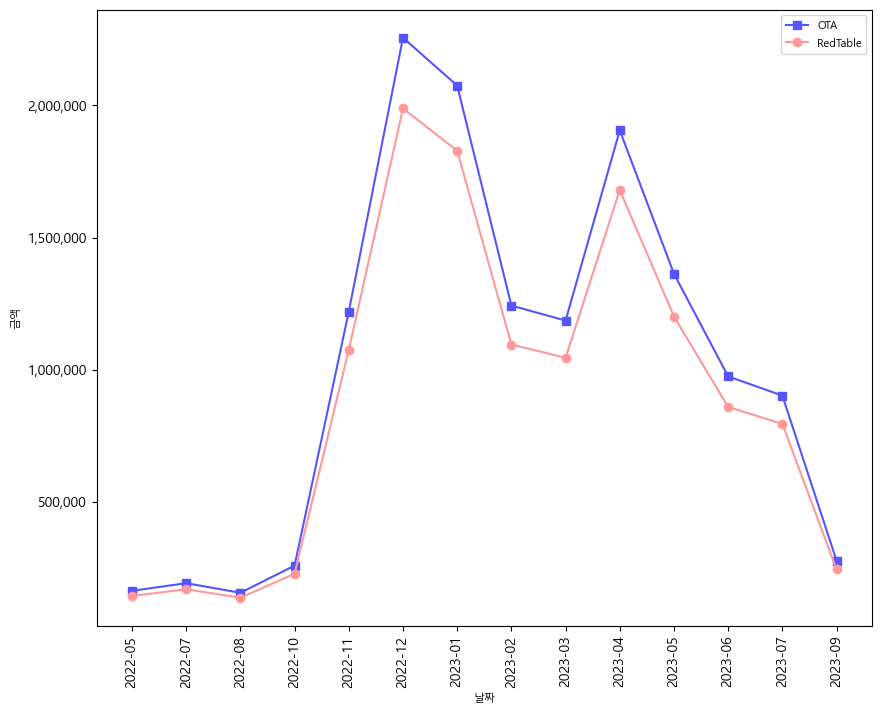

In [5]:
def Real_Price_each(df, is_cumsum):

    df = df.drop_duplicates('order_id')
    df = df[df['v.status'] == 'used']    
    
    plt.figure(figsize=(10,8)) # 차트 생성 및 사이즈 설정

    price_ratio = get_ota_info()[1]

    if is_cumsum == False:

        df = df.groupby(['year','month'])['real_price'].sum().reset_index()
        df['year-month'] = df['year'] + '-' + df['month']
        plt.plot(df['year-month'], [float(i) * (1+price_ratio) for i in df['real_price'].values.tolist()], label='OTA', color = '#5555ff', marker = 's')
        plt.plot(df['year-month'], df['real_price'], label='RedTable', color='#ff9999', marker = 'o')

    elif is_cumsum == True:

        df = df.groupby(['year','month'])['real_price'].sum().reset_index()
        df['cumsum'] = df['real_price'].cumsum()
        df['year-month'] = df['year'] + '-' + df['month']

        plt.plot(df['year-month'], [float(i) * (1+price_ratio) for i in df['cumsum'].values.tolist()], label='OTA', color = '#5555ff', marker = 's')
        plt.plot(df['year-month'], df['cumsum'], label='RedTable', color='#ff9999', marker = 'o')

    plt.ylabel('금액', fontsize=8, loc='center') # x축 설정
    plt.xlabel('날짜', fontsize=8, loc='center') # y축 설정

    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
    plt.xticks(rotation=90)
    plt.legend(fontsize=8, loc='best') # 범례 설정 best로 해놓으면 가장 적절한 위치에 알아서 범례가 놓이게 됩니디
    
    plt.show()

    return df

Real_Price_each_df = Real_Price_each(pms_order, False)

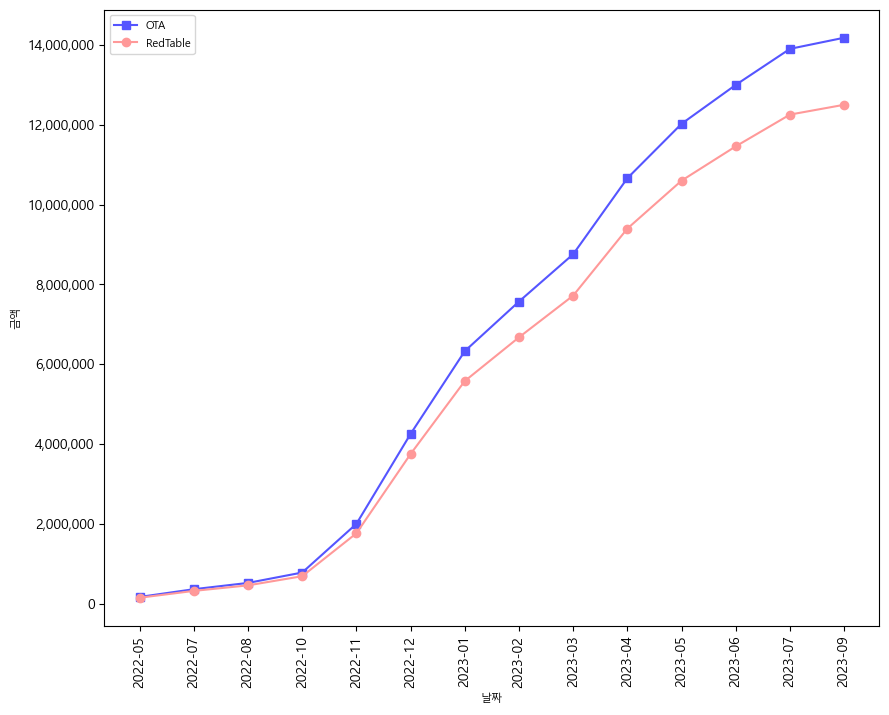

In [6]:
def Real_Price_cumsum(df, is_cumsum):

    df = df.drop_duplicates('order_id')
    df = df[df['v.status'] == 'used']

    price_ratio = get_ota_info()[1]

    plt.figure(figsize=(10,8)) # 차트 생성 및 사이즈 설정
    
    if is_cumsum == False:

        df = df.groupby(['year','month'])['real_price'].sum().reset_index()
        df['year-month'] = df['year'] + '-' + df['month']
        plt.plot(df['year-month'], [float(i) * (1+price_ratio) for i in df['real_price'].values.tolist()], label='OTA', color = '#5555ff', marker = 's')
        plt.plot(df['year-month'], df['real_price'], label='RedTable', color='#ff9999', marker = 'o')


    elif is_cumsum == True:

        df = df.groupby(['year','month'])['real_price'].sum().reset_index()
        df['cumsum'] = df['real_price'].cumsum()
        df['year-month'] = df['year'] + '-' + df['month']

        plt.plot(df['year-month'], [float(i) * (1+price_ratio) for i in df['cumsum'].values.tolist()], label='OTA', color = '#5555ff', marker = 's')
        plt.plot(df['year-month'], df['cumsum'], label='RedTable', color='#ff9999', marker = 'o')

    plt.ylabel('금액', fontsize=8, loc='center') 
    plt.xlabel('날짜', fontsize=8, loc='center') 

    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
    plt.xticks(rotation=90)
    plt.legend(fontsize=8, loc='best') 
    
    plt.show()

    return df

Real_Price_cumsum_df = Real_Price_cumsum(pms_order, True)

2. 요일별 결제 금액 합

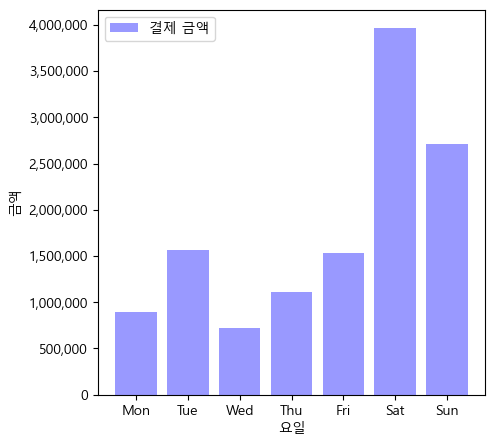

In [7]:
def daily7_RealPrice(df):
    
    df = df[df['v.status'] == 'used']
    df = df.drop_duplicates('order_id')

    day7_dic = {'Mon':0,'Tue':1,'Wed':2,'Thu':3,'Fri':4,'Sat':5,'Sun':6}
    reverse_day7_dic = {v:k for k,v in day7_dic.items()}
    df_Group_BY = df.groupby(['day_7'])['real_price'].sum().reset_index()
    df_Group_BY['day_7'] = df_Group_BY['day_7'].apply(lambda x:day7_dic[x])
    df_Group_BY.sort_values(by='day_7', inplace=True)
    df_Group_BY['day_7'] = df_Group_BY['day_7'].apply(lambda x:reverse_day7_dic[x])
    df_Group_BY.set_index(np.arange(0,len(df_Group_BY)),inplace=True)
    plt.figure(figsize=(5,5))
    plt.bar(df_Group_BY['day_7'], df_Group_BY['real_price'], label='결제 금액', color='#9999ff')
    
    plt.ylabel('금액', fontsize=10, loc='center') 
    plt.xlabel('요일', fontsize=10, loc='center') 

    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
    
    plt.legend(fontsize=10, loc='best') 

    plt.show()

    
daily7_RealPrice(pms_order)

3. 결제 금액 조회

In [8]:
def Sum_RealPrice(df, string):

    df = df.drop_duplicates('order_id')
    
    cond1 = df['year-month-day'] == string
    cond2 = df['v.status'] == 'used'
    total_cond = cond1 & cond2
    conditioned_df = df[total_cond]

    mop = int(conditioned_df['real_price'].sum())

    return mop

Order_Price_Sum = Sum_RealPrice(pms_order, '2023-09-16')

Order_Price_Sum

246000

6. 예약 수(누적 + OTA)

- 월별 건수를 보여주며 추세를 보여주는 것보다는 누적을 보여주고 이에 OTA의 효과를 보여주는 것이 점주의 액션을 더 이끌어낼 것이라고 판단

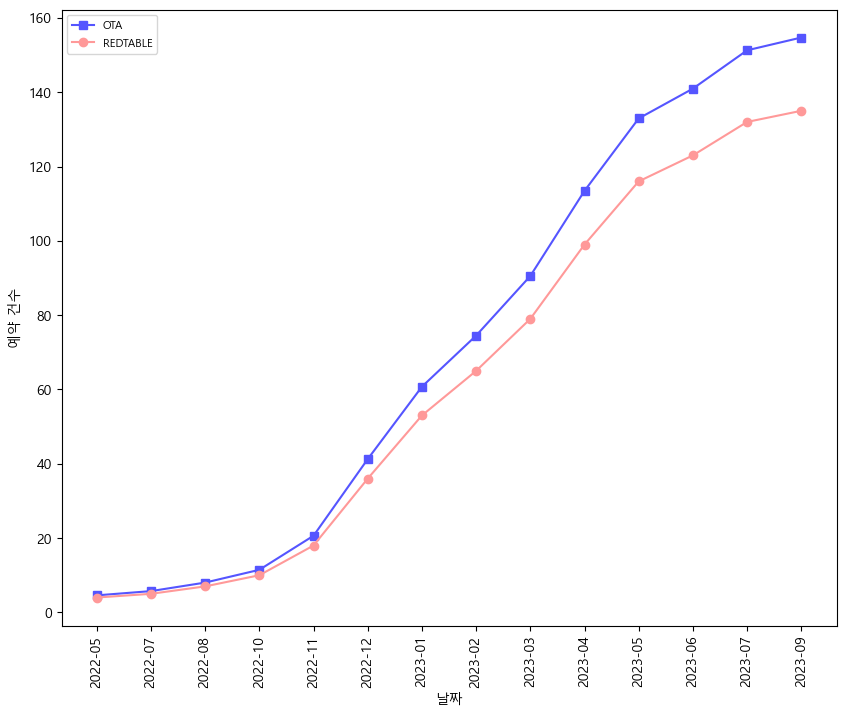

In [9]:
def paid_order(df):

    df = df[(df['status'] == 'paid') & (df['v.status'] == 'used')]
    df = df.drop_duplicates('order_id')

    order_ratio = get_ota_info()[0]
    
    plt.figure(figsize=(10, 8)) # 차트 생성 및 사이즈 설정

    df = df.groupby(['year','month'])['order_id'].nunique().reset_index()
    df['year-month'] = df['year'] + '-' + df['month']
    plt.plot(df['year-month'], [float(i) * (1+order_ratio) for i in df['order_id'].cumsum().values.tolist()], label='OTA', color = '#5555ff', marker = 's')
    plt.plot(df['year-month'], df['order_id'].cumsum(), label='REDTABLE', color='#ff9999', marker = 'o')
            
    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
    # plt.title('예약 건수', fontsize=10) # 타이틀 설정
    plt.ylabel('예약 건수', fontsize=10) # x축 설정
    plt.xlabel('날짜', fontsize=10) # y축 설정
    plt.xticks(rotation=90)
    plt.legend(fontsize=8, loc='best') # 범례 설정 best로 해놓으면 가장 적절한 위치에 알아서 범례가 놓이게 됩니디

    plt.show()

    return df

paid_order_df = paid_order(pms_order)

7. 기준별 예약자 수

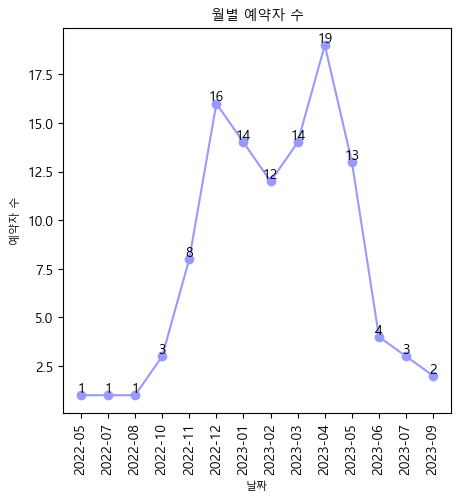

In [10]:
def yearly_N_users(df):
    
    df = df[df['v.status'] == 'used']
    no_duplc = df.drop_duplicates(['year','user_id'])
    gb1 = no_duplc.groupby(['year'])['user_id'].value_counts().reset_index()
    gb2 = gb1.groupby(['year'])['count'].sum().reset_index()
    gb2.columns = ['a','b']

    return gb2

def monthly_N_users(df):

    df = df[df['v.status'] == 'used']
    no_duplc = df.drop_duplicates(['year','month','user_id'])
    gb1 = no_duplc.groupby(['year','month'])['user_id'].value_counts().reset_index()
    gb2 = gb1.groupby(['year','month'])['count'].sum().reset_index()
    gb2['year-month'] = gb2['year'] + '-' + gb2['month']
    gb2 = gb2.drop(['year','month'],axis=1)
    gb2.columns = ['b','a']
    
    return gb2

def daily_N_users(df):
    
    df = df[df['v.status'] == 'used']
    no_duplc = df.drop_duplicates(['year','month','day','user_id'])
    gb1 = no_duplc.groupby(['year','month','day'])['user_id'].value_counts().reset_index()
    gb2 = gb1.groupby(['year','month','day'])['count'].sum().reset_index()
    gb2['year-month-day'] = gb2['year'] + '-' + gb2['month'] + '-' + gb2['day']
    gb2 = gb2.drop(['year','month','day'],axis=1)
    gb2.columns = ['a','b']

    return gb2

def N_users(df, time_criteria):
    
    if time_criteria == '연별':

        df = yearly_N_users(df)
        
    elif time_criteria == '월별':

        df = monthly_N_users(df)

    elif time_criteria == '일별':

        df = daily_N_users(df)

    graph_title = time_criteria + ' 예약자 수'

    plt.figure(figsize=(5, 5))
    plt.plot(df['a'], df['b'], label='users', color='#9999ff', marker = 'o')

    for i in range(len(df)):
        plt.text(df['a'][i], df['b'][i], df['b'][i], ha='center', va='bottom')

    plt.title(graph_title, fontsize=10) # 타이틀 설정
    plt.ylabel('예약자 수', fontsize=8) # x축 설정
    plt.xlabel('날짜', fontsize=8) # y축 설정
    plt.xticks(rotation=90)


    plt.show()

N_users(pms_order, '월별')

8. 월별 사용된 바우처 수

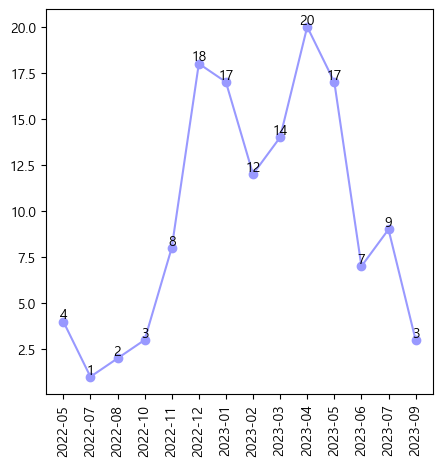

In [11]:
def N_used_vouchers(df):

    df = df.drop_duplicates('order_id')
    
    cond = df['v.status'] == 'used'

    conditioned_df = df[cond]

    # no_duplc = conditioned_df.drop_duplicates(['year','month','voucher_id'])
    gb1 = conditioned_df.groupby(['year','month'])['voucher_id'].value_counts().reset_index()
    gb2 = gb1.groupby(['year','month'])['count'].sum().reset_index()
    gb2['year-month'] = gb2['year'] + '-' + gb2['month']
    gb2 = gb2.drop(['year','month'],axis=1)
    gb2.columns = ['b','a']
    
    plt.figure(figsize=(5, 5))
    plt.plot(gb2['a'], gb2['b'], label='users', color='#9999ff', marker = 'o')

    for i in range(len(gb2)):
        plt.text(gb2['a'][i], gb2['b'][i], gb2['b'][i], ha='center', va='bottom')
    plt.xticks(rotation=90)
    plt.show()

N_used_vouchers(pms_order)

9. 기간 내 언어별 사용자 수

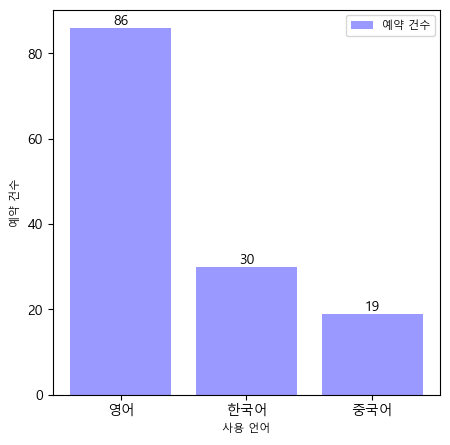

In [12]:
def N_used_langs(df):

    df = df[df['v.status'] == 'used']
    df = df.drop_duplicates('order_id')
    
    lang_vc = df['order_lang'].value_counts().reset_index()
    lang_dic = {'en':'영어','ko':'한국어','zh-Hans':'중국어'}
    lang_vc['order_lang'] = lang_vc['order_lang'].apply(lambda x:lang_dic[x])
    plt.figure(figsize=(5,5))
    plt.bar(lang_vc['order_lang'], lang_vc['count'], label='예약 건수', facecolor='#9999ff')
    # plt.title('사용 언어 별 예약 건수', fontsize=10) # 타이틀 설정
    plt.ylabel('예약 건수', fontsize=8) # x축 설정
    plt.xlabel('사용 언어', fontsize=8) # y축 설정

    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
    
    plt.legend(fontsize=8, loc='best') # 범례 설정 best로 해놓으면 가장 적절한 위치에 알아서 범례가 놓이게 됩니디

    for i in range(len(lang_vc)):
        plt.text(lang_vc['order_lang'][i], lang_vc['count'][i], lang_vc['count'][i], ha='center', va='bottom')
    
    plt.show()

N_used_langs(pms_order)

10. 평균 팀당 인원 수

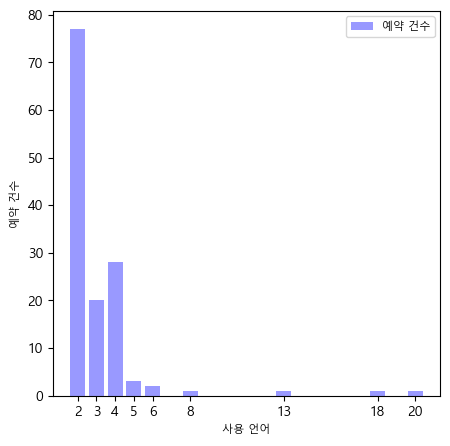

'예약 팀당 최다 인원 수는 20명이며, 가장 많은 예약이 발생한 팀의 인원 수는 2명입니다. 예약 팀당 평균 인원 수는 3.05명입니다. '

In [13]:
def N_person_avg_per_team(df):
    
    df = df.drop_duplicates('order_id')
    df = df[df['v.status'] == 'used']
    # df = df[(df['reserved_at'] >= start_date) & (df['reserved_at'] <= end_date)]
    pn_dic = dict(df['person_num'].value_counts().sort_index())
    pn_dic = {k:v for k,v in pn_dic.items() if k >= 1}

    max_order_num = df['person_num'].value_counts().index[0]
    N_max = df['person_num'].max()
    N_avg = df['person_num'].mean()

    plt.figure(figsize=(5,5))
    plt.bar(list(pn_dic.keys()), list(pn_dic.values()), label='예약 건수', facecolor='#9999ff')
    # plt.title('사용 언어 별 예약 건수', fontsize=10) # 타이틀 설정
    plt.ylabel('예약 건수', fontsize=8) # x축 설정
    plt.xlabel('사용 언어', fontsize=8) # y축 설정
    plt.xticks(list(pn_dic.keys()))
    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
    
    plt.legend(fontsize=8, loc='best')
    plt.show()
    text = "예약 팀당 최다 인원 수는 {}명이며, 가장 많은 예약이 발생한 팀의 인원 수는 {}명입니다. 예약 팀당 평균 인원 수는 {}명입니다. ".format(N_max, max_order_num, round(N_avg,2))

    return text

person_avg_per_team = N_person_avg_per_team(pms_order)

person_avg_per_team

11. 최다 판매 상품

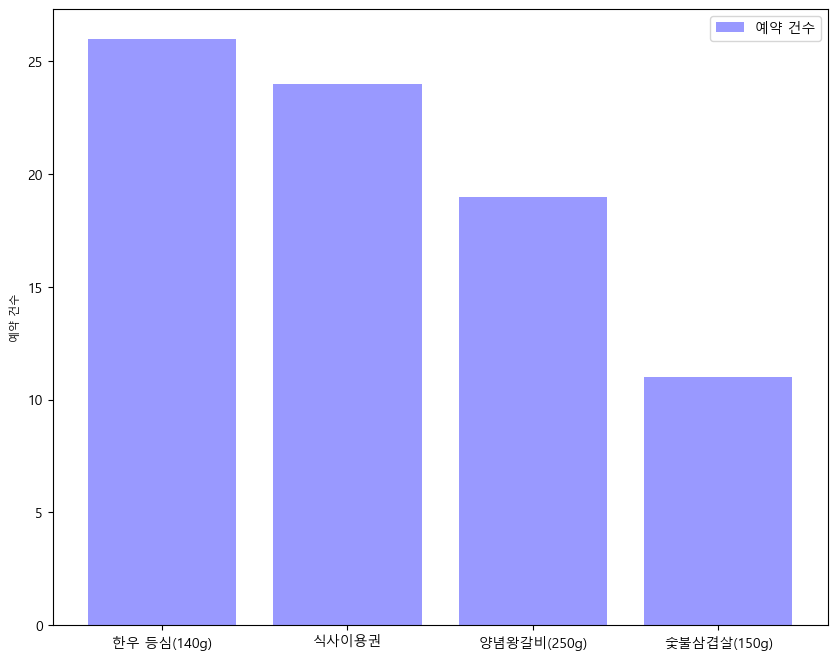

'최다 판매 상품은 [한우 등심(140g)] 상품으로, 총 26건의 예약 건수가 있습니다.'

In [14]:
def hot_product(df):

    df = df[df['v.status'] == 'used']
    df = df.drop_duplicates('order_id')

    top5_idx = df['product_id'].value_counts()[:5].index.tolist()
    top5_vals = df['product_id'].value_counts()[:5].values.tolist()

    conn = live_db_conn()
    curs = conn.cursor()

    sql = """
    SELECT id, name, price
    FROM product
    where id in {}
    """.format(tuple(top5_idx))
    curs.execute(sql)

    product = pd.DataFrame(curs.fetchall())

    curs.close()
    conn.close()
    idx_name = {idx:product[product['id'] == idx]['name'].values[0] for idx in top5_idx}
    
    plt.figure(figsize=(10,8))
    plt.bar(idx_name.values(), top5_vals, label='예약 건수', facecolor='#9999ff')
    plt.ylabel('예약 건수', fontsize=8) # x축 설정
    # plt.xlabel('사용 언어', fontsize=8) # y축 설정

    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
    
    plt.legend(fontsize=10, loc='best') # 범례 설정 best로 해놓으면 가장 적절한 위치에 알아서 범례가 놓이게 됩니디

    # for i in range(len(lang_vc)):
    #     plt.text(lang_vc['order_lang'][i], lang_vc['count'][i], lang_vc['count'][i], ha='center', va='bottom')
    
    plt.show()

    text = '최다 판매 상품은 [{}] 상품으로, 총 {}건의 예약 건수가 있습니다.'.format(list(idx_name.values())[0], top5_vals[0])

    return text

hot_product(pms_order)

12. 인기 시간대

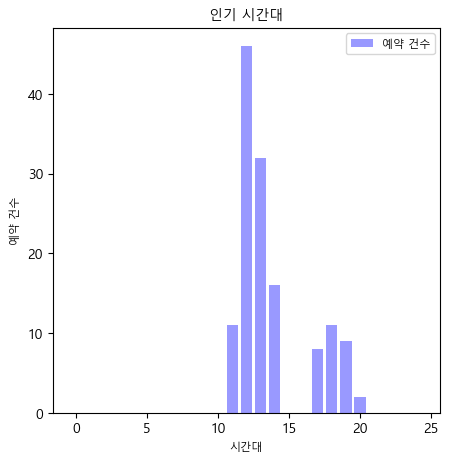

In [15]:
def hot_hour(df):

    df = df[df['v.status'] == 'used']
    df = df.drop_duplicates('order_id')
    hot_hour = df['hour'].value_counts().reset_index()
    hot_hour['hour'] = hot_hour['hour'].apply(lambda x:int(x))
    tmp_list = [[i,0] for i in np.arange(0,25).tolist() if i not in hot_hour['hour'].unique().tolist()]

    for i in range(len(tmp_list)):
        hot_hour= pd.concat([hot_hour, pd.DataFrame([tmp_list[i]],columns=['hour','count'])])
    hot_hour.sort_values(by='hour',inplace=True)

    plt.figure(figsize=(5,5))
    plt.bar(hot_hour['hour'], hot_hour['count'], label='예약 건수', facecolor='#9999ff')
    plt.title('인기 시간대', fontsize=10) # 타이틀 설정
    plt.ylabel('예약 건수', fontsize=8) # x축 설정
    plt.xlabel('시간대', fontsize=8) # y축 설정

    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
    
    plt.legend(fontsize=8, loc='best')
    plt.show()

hot_hour(pms_order)

13. 고객 현황 누적/일별 그래프

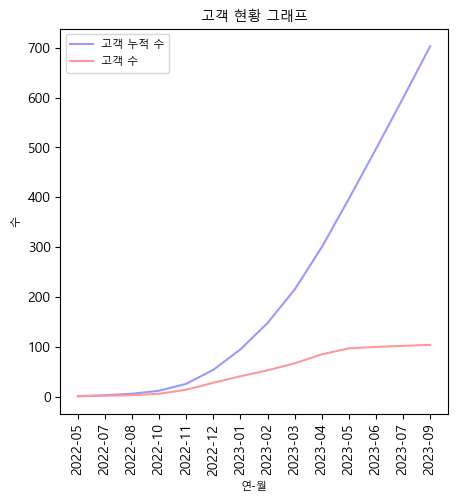

In [16]:
def N_users_cumsum(df):
    
    df = df[df['v.status'] == 'used']
    df = df.drop_duplicates('order_id')

    N_users_cumsum_df = df.drop_duplicates('user_id').groupby(['year','month'])['user_id'].value_counts().cumsum().reset_index().drop('user_id',axis=1).drop_duplicates(['year','month'],keep='last')
    N_users_cumsum_df['year-month'] = N_users_cumsum_df['year'] + '-' + N_users_cumsum_df['month']
    plt.figure(figsize=(5,5)) # 차트 생성 및 사이즈 설정

    plt.plot(N_users_cumsum_df['year-month'], N_users_cumsum_df['count'].cumsum(), label='고객 누적 수', color='#9999ff') # CLOU 종가 불러오기
    plt.plot(N_users_cumsum_df['year-month'], N_users_cumsum_df['count'], label='고객 수', color='#ff9999')

    plt.title('고객 현황 그래프', fontsize=10) # 타이틀 설정
    plt.ylabel('수', fontsize=8) # x축 설정
    plt.xlabel('연-월', fontsize=8) # y축 설정

    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
    plt.xticks(rotation=90)
    plt.legend(fontsize=8, loc='best') # 범례 설정 best로 해놓으면 가장 적절한 위치에 알아서 범례가 놓이게 됩니디
    
    plt.show()

N_users_cumsum(pms_order)

In [17]:
def google_review_ethan(store_id):

    conn = dev_raw_db_conn()
    curs = conn.cursor()

    sql = """
    select live_store_id, reviewer_name, reviewer_stars, review_detail, date_detail as date
    from ethan_google_review_detail
    where live_store_id = {}
    """.format(store_id)
    curs.execute(sql)
    google_review = pd.DataFrame(curs.fetchall())

    curs.close()
    conn.close()
    
    google_review.dropna(inplace=True)

    return google_review

def google_review_emile(store_id):

    conn = dev_raw_db_conn()
    curs = conn.cursor()

    sql = """
    SELECT STORE_ID as live_store_id, reviewer_name, reviewer_star as reviewer_stars, review_detail, date_detail as date
    FROM emile_google_review_detail
    where reviewer_star is not null
    and STORE_ID = {}
    """.format(store_id)
    curs.execute(sql)
    google_review = pd.DataFrame(curs.fetchall())

    curs.close()
    conn.close()

    return google_review

def dev_naver_review(store_id):

    conn = dev_raw_db_conn()
    curs = conn.cursor()

    sql = """
    SELECT A.RSTR_ID, A.SRC_ID as store_id, B.SRC_ID as naver_src_id FROM (SELECT * FROM redtable01.RSTR_CONN where SRC='live_db') A
    join (SELECT * FROM redtable01.RSTR_CONN where SRC='naver') B on A.RSTR_id=B.RSTR_id
    where A.SRC_ID = {};
    """.format(store_id)
    curs.execute(sql)
    store_conn = pd.DataFrame(curs.fetchall())

    if len(store_conn) != 0:
        sql = """
        SELECT *
        FROM naver_review
        where rating is not null
        and restaurant_id = {}
        """.format(store_conn['naver_src_id'][0])
        curs.execute(sql)
        naver_review = pd.DataFrame(curs.fetchall())
    
    else:

        naver_review = pd.DataFrame()

    curs.close()
    conn.close()


    return store_conn, naver_review

14. 리뷰 수

In [18]:
def change_format(string):

    changed_str = string[:-2].replace('.','-')
    newDate = datetime.strptime(changed_str, '%y-%m-%d')

    return newDate

In [19]:
def N_total_review(store_id, start_date, end_date):

    google_review_ethan_df = google_review_ethan(store_id)
    google_review_emile_df = google_review_emile(store_id)

    google_review = pd.concat([google_review_ethan_df, google_review_emile_df])

    
    store_conn, naver_review = dev_naver_review(store_id)

    if len(naver_review) != 0:
        
        naver_review.drop_duplicates(['writer_id','restaurant_id','visited'], inplace=True)
        naver_review = pd.merge(naver_review, store_conn, how='left', left_on = 'restaurant_id', right_on = 'naver_src_id').drop(['RSTR_ID','naver_src_id'],axis=1)
        naver_review = naver_review[['store_id','writer_id','rating','visited','content']].rename(columns={'store_id':'live_store_id','writer_id':'reviewer_name','rating':'reviewer_stars','content':'review_detail','visited':'date'})
        naver_review['date'] = naver_review['date'].apply(lambda x:change_format(x)) 
        
        total_review = pd.concat([google_review, naver_review])

    else:
    
        total_review = google_review



    try:

        total_review = total_review[(total_review['date'] >= start_date) & (total_review['date'] <= end_date)]
        total_review.sort_values(by='date', inplace=True)
        total_review['year'] = total_review['date'].apply(lambda x:str(x).split('-')[0])
        total_review['month'] = total_review['date'].apply(lambda x:str(x).split('-')[1])

        # plot_df = total_review.groupby(['year','month'])['live_store_id'].value_counts().reset_index()
        # plot_df['year_month'] = plot_df['year'] + '-' + plot_df['month']
        # plt.figure(figsize=(5,5)) # 차트 생성 및 사이즈 설정

        # plt.plot(plot_df['year_month'], plot_df['count'].cumsum(), label='리뷰 누적 수', color='#9999ff') # CLOU 종가 불러오기
        # plt.plot(plot_df['year_month'], plot_df['count'], label='리뷰 수', color='#ff9999')
        # plt.title('리뷰 현황 그래프')
        # plt.ylabel('리뷰 수', fontsize=8) # x축 설정
        # plt.xlabel('연-월', fontsize=8) # y축 설정
        # plt.xticks(rotation=90)
        # plt.legend(fontsize=8, loc='best') # 범례 설정 best로 해놓으면 가장 적절한 위치에 알아서 범례가 놓이게 됩니디
        # plt.show()

    except:

        print('해당 기간에 조회 로그가 없습니다.')

    return total_review
    

N_total_review_df = N_total_review(target, '2023-01-01', '2023-05-30')

15. 검색량 (Live_event)

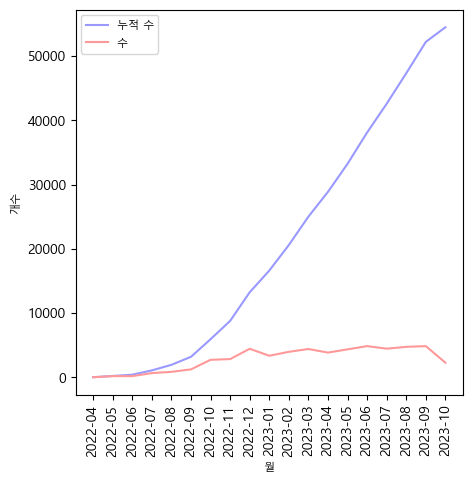

In [20]:
def live_event(store_id, start_date, end_date):

    conn = live_db_conn()
    curs = conn.cursor()

    sql = """
    SELECT * FROM live_event
    where store_id = {} 
    and created_at >= '{}'
    and created_at <= '{}'
    """.format(store_id, start_date, end_date)
    curs.execute(sql)

    live_event = pd.DataFrame(curs.fetchall())

    curs.close()
    conn.close()
    
    try:
        live_event['year'] = live_event['created_at'].apply(lambda x:str(x).split('-')[0])
        live_event['month'] = live_event['created_at'].apply(lambda x:str(x).split('-')[1])

        plot_df = live_event.groupby(['year','month'])['store_id'].value_counts().reset_index()
        plot_df['year_month'] = plot_df['year'] + '-' + plot_df['month']
        plt.figure(figsize=(5, 5)) # 차트 생성 및 사이즈 설정

        plt.plot(plot_df['year_month'], plot_df['count'].cumsum(), label='누적 수', color='#9999ff') # CLOU 종가 불러오기
        plt.plot(plot_df['year_month'], plot_df['count'], label='수', color='#ff9999')

        plt.ylabel('개수', fontsize=8) # x축 설정
        plt.xlabel('월', fontsize=8) # y축 설정

        # current_values = plt.gca().get_yticks()
        # plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
        plt.xticks(rotation=90)
        plt.legend(fontsize=8, loc='best') # 범례 설정 best로 해놓으면 가장 적절한 위치에 알아서 범례가 놓이게 됩니디
        plt.show()

    except:

        print('해당 기간에 조회 로그가 없습니다.')

live_event(target,'2021-04-01', '2023-12-31')

16. 리뷰 키워드

['이 장소는 우리 여행의 하이라이트입니다. 우리는 2명뿐이었기 때문에 바로 테이블을 얻을 수 있어서 운이 좋았습니다. 더 큰 그룹으로 오는 경우 미리 예약하지 않는 한 기다려야 합니다.\n\n우리는 쇠고기 손가락, 삼겹살, 생 쇠고기 타르타르, 매운 냉면을 주문했는데 모든 것이 절대적으로 맛있습니다.\n\n이곳의 밑반찬도 다른 kbbq집보다 고급스럽고 맛도 좋습니다.\n\n모든 직원은 좋은 영어를 구사합니다. 그들은 매우 정중하고 빠르게 일하며 고기도 완벽하게 요리합니다.\n\n직원은 또한 그들이 제공하는 돼지 고기는 매우 신선하여 고기를 80%까지 익힐 수 있다고 말합니다. 나는 그것에 대해 확신하지 못했기 때문에 우리는 여전히 그들에게 100% 요리를 요청했습니다 😌. 하지만 와우, 돼지고기를 약간 날 것으로 먹을 수 있다는 것을 몰랐습니까?\n\n나는 곧 한국에 오는 많은 친구들에게 이 장소를 공유했습니다. 그들이 우리만큼 경험을 사랑하기를 바랍니다.', '잊을 수 없는 식사 경험을 찾고 있다면 이 놀라운 한국식 BBQ 장소를 찾으십시오! 들어서는 순간부터 고소하고 향긋한 풍미와 타의 추종을 불허하는 환대의 세계로 이동하게 될 것입니다.\n\n우선, 분위기는 놀랍습니다. 세련되고 현대적인 장식부터 지글거리는 그릴 소리까지. 그리고 그릴 얘기가 나와서 말인데 여기 고기가 이 세상에 없군요!\n\n그러나 그것은 고기에 관한 것이 아닙니다. 반찬도 놀랍습니다. 톡 쏘는 김치부터 보송보송한 밥까지, 모든 요리는 풍미와 진품으로 가득 차 있습니다. 구운 고기를 완벽하게 보완하는 작은 요리 모음인 다양한 종류의 반찬을 맛보는 것을 잊지 마십시오.\n\n여기의 서비스도 최고 수준입니다. 직원은 지식이 풍부하고 친절하며 항상 기꺼이 질문에 답변하고 권장 사항을 제공합니다. 그리고 그들은 당신의 그릴을 뜨겁게 유지하고 밤새도록 당신의 음료를 가득 채울 것입니다.\n\n대체로 이 한국식 BBQ 장소는 진정으로 특별한 식사 경험을 원하는 사람이라면 반드시 방문해야 할 곳입

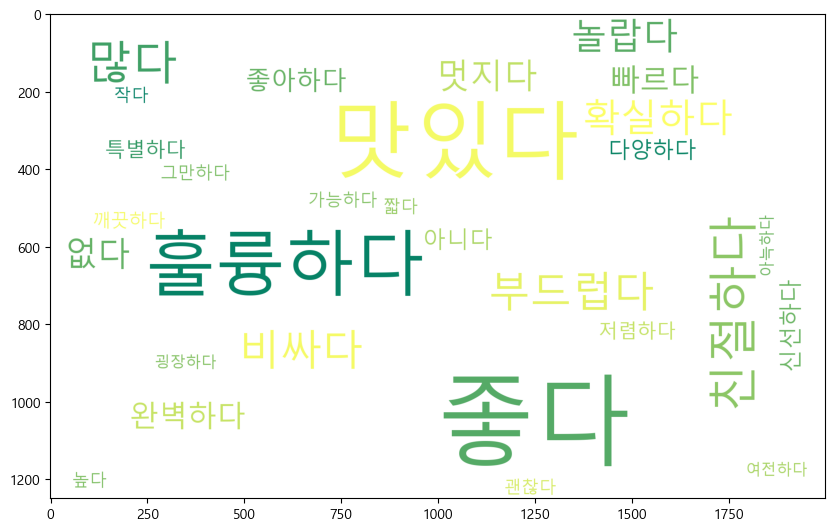

In [24]:
def review_WordCloud(df):

    text = df['review_detail'].tolist()
    review_dic = {}
    okt = Okt()
    review_dic = {}
    total_words = []
    for i in range(len(text)):

        okt_pos = okt.pos(str(text[i]), norm=True, stem=True)
        idx_words = [(x,y[0]) for x,y in enumerate(okt_pos) if len(y[0]) > 1 and y[1] in ['Adjective']] # 단어의 길이가 1개인 것은 제외
        stop_words = ['하다','않다','이다','있다','그렇다','싶다','같다','당신','정도','인분','그것']
        words = [x[1] for x in idx_words if x[1] not in stop_words]
        total_words.extend(words)
        review_dic[i]=len(words)
        
    sorted_rd = dict(sorted(review_dic.items(),reverse=True, key=lambda x:x[1]))
    top3_review = [text[i] for i in range(len(text)) if i in list(sorted_rd.keys())[:3]]
    
    c = Counter(total_words)
    c = {k:v for k,v in c.items() if v >= 5}
    return_c = dict(sorted(c.items(), key=lambda x:x[1], reverse=True))
    wc = WordCloud(font_path='malgun', width=800, height=500, scale=2.5, max_font_size=100, background_color='white', colormap='summer')
    gen = wc.generate_from_frequencies(c)
    plt.figure(figsize=(10,8))
    plt.imshow(gen)

    return  top3_review, return_c

top3_review, return_c = review_WordCloud(N_total_review_df)

print(top3_review)
print(return_c)

17. 리뷰 긍부정

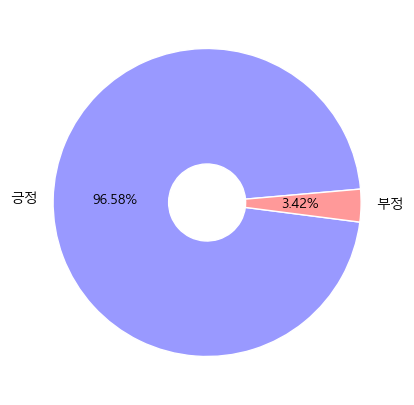

매장의 총 리뷰 1052개 중, 긍정적 리뷰는 96.5779%, 부정적 리뷰는 3.42205%입니다.


In [22]:
def review_pn_ratio(target):

    conn = dev_raw_db_conn()
    curs = conn.cursor()

    sql = """
    SELECT * 
    FROM thomas_store_review_pn
    where live_store_id = {}
    """.format(target)
    curs.execute(sql)
    review_pn = pd.DataFrame(curs.fetchall())

    curs.close()
    conn.close()
    vals = review_pn.values[0]
    cnt = int(vals[1])
    p = vals[2]
    n = vals[3]
    text = '매장의 총 리뷰 {}개 중, 긍정적 리뷰는 {}%, 부정적 리뷰는 {}%입니다.'.format(cnt,p,n)

    ratio = [p,n]
    label = ['긍정','부정']
    colors = ['#9999ff','#ff9999']
    wedgeprops={'width': 0.75, 'edgecolor': 'w', 'linewidth': 1}

    plt.figure(figsize=(5, 5)) # 차트 생성 및 사이즈 설정
    plt.pie(ratio,labels=label,autopct='%.2f%%',startangle=365,colors=colors, wedgeprops=wedgeprops)
    plt.show()

    return text

review_pn = review_pn_ratio(target)

print(review_pn)

18. OTA별 정보

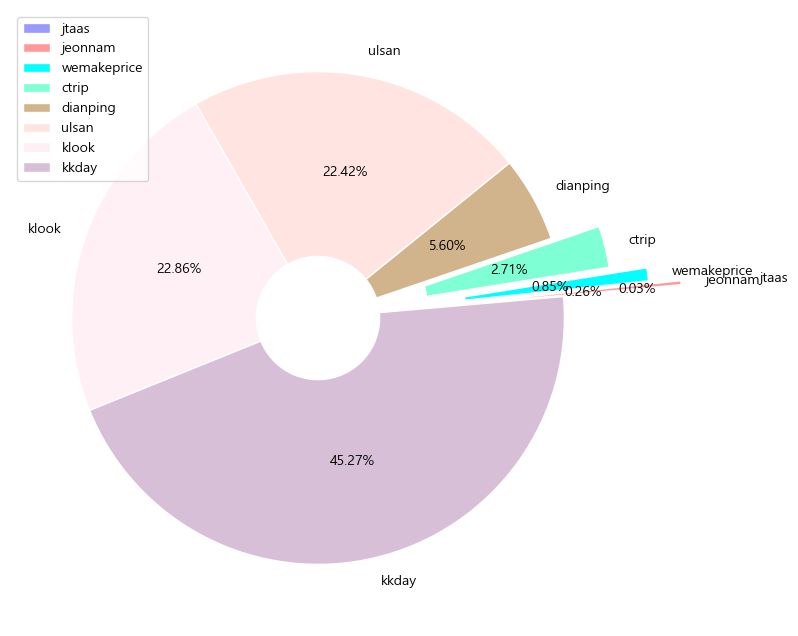

In [23]:
def get_ota_dic():

    conn = live_db_conn()
    curs = conn.cursor()

    sql = """
    SELECT id, code
    FROM ota
    """
    curs.execute(sql)

    ota = pd.DataFrame(curs.fetchall())

    curs.close()
    conn.close()

    ota_dic = {vals[0]:vals[1] for vals in ota.values}

    return ota_dic


def ota_ratio_chart():
    
    order = order_table()
    ota_dic = get_ota_dic()
    ratio = {ota_dic[i]:len(order[order['ota_id'] == i]) / len(order) for i in range(2,15) if len(order[order['ota_id'] == i]) != 0}
    ratio = dict(sorted(ratio.items(), key=lambda x:x[1], reverse=False))

    colors = ['#9999ff','#ff9999','#00FFFF','#7FFFD4','tan','mistyrose','lavenderblush','thistle']
    wedgeprops={'width': 0.75, 'edgecolor': 'w', 'linewidth': 1}
    explode = [0,0,0,0,0.2,0.35,0.48,0.70]
    plt.figure(figsize=(10,8)) # 차트 생성 및 사이즈 설정
    plt.pie(ratio.values(),labels=ratio.keys(),autopct='%.2f%%',explode = explode[::-1], colors=colors[:len(ratio)],startangle=365, wedgeprops=wedgeprops)
    plt.legend(fontsize=10, loc='upper left')
    plt.show()

    return ratio

ota_ratio = ota_ratio_chart()